In [10]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [11]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 104.7 GB  | Proc size: 634.9 MB
GPU RAM Free: 14884MB | Used: 1284MB | Util   8% | Total 16376MB


In [12]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5, ))]
    )
    trainset = MNIST("./dataset", train=True, download=True, transform=transform)
    testset = MNIST("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

In [13]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [14]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [15]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times = {}
        self.client_metrics = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [16]:
# if DEVICE.type == "cuda":
#     # Use a single client to train the global model
#     client_resources = { "num_cpus": 2} 
# client_resources = { "num_cpus": 2} 

In [17]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [19]:
strategy = FedCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,  # <-- pass the new strategy here
    client_resources=client_resources,

)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
(raylet) unknown [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
2024-07-16 10:43:42,961	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 62921182208.0, 'accelerator_type:RTX': 1.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0, 'object_store_memory': 31251935232.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided

This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48296) Training time for Client 9: 27.11 seconds
(ClientAppActor pid=48296) Epoch 9: train loss 0.001291, accuracy 0.987222 [repeated 4x across cluster]
(ClientAppActor pid=35596) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 25.053230047225952and 8habhhahah
this is tehb mode time [25.05]
This is ths last time not a fantasy 24.920217037200928and 3habhhahah
this is tehb mode time [25.05, 24.92]
This is ths last time not a fantasy 25.20403480529785and 7habhhahah
this is tehb mode time [25.05, 24.92, 25.2]
This is ths last time not a fantasy 24.46231484413147and 2habhhahah
this is tehb mode time [25.05, 24.92, 25.2, 24.46]
This is ths last time not a fantasy 24.81388831138611and 6habhhahah
this is tehb mode time [25.05, 24.92, 25.2, 24.46, 24.81]
This is ths last time not a fantasy 24.601338863372803and 4habhhahah
this is tehb mode time [25.05, 24.92, 25.2, 24.46, 24.81, 24.6]
This is ths last time not a fantasy 24.935222864151and 5habhhahah
this is tehb mode time [25.05, 24.92, 25.2, 24.46, 24.81, 24.6, 24.94]
This is ths last time not a fantasy 27.239190101623535and 1habhhahah
this is tehb mode time [25.05, 24.92, 25.2, 24.46, 24.81, 24.6, 24.94, 27.24]
This is ths last ti

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55460) Training time for Client 0: 23.70 seconds
(ClientAppActor pid=48296) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.036330699920654and 6habhhahah
this is tehb mode time [22.04]
This is ths last time not a fantasy 23.938721895217896and 9habhhahah
this is tehb mode time [22.04, 23.94]
This is ths last time not a fantasy 22.627832651138306and 7habhhahah
this is tehb mode time [22.04, 23.94, 22.63]
This is ths last time not a fantasy 21.539668798446655and 5habhhahah
this is tehb mode time [22.04, 23.94, 22.63, 21.54]
This is ths last time not a fantasy 21.613659381866455and 1habhhahah
this is tehb mode time [22.04, 23.94, 22.63, 21.54, 21.61]
This is ths last time not a fantasy 21.81064510345459and 8habhhahah
this is tehb mode time [22.04, 23.94, 22.63, 21.54, 21.61, 21.81]
This is ths last time not a fantasy 23.696176528930664and 0habhhahah
this is tehb mode time [22.04, 23.94, 22.63, 21.54, 21.61, 21.81, 23.7]
This is ths last time not a fantasy 22.213086366653442and 3habhhahah
this is tehb mode time [22.04, 23.94, 22.63, 21.54, 21.61, 21.81, 23.7, 22.21]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17132) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.968544483184814and 3habhhahah
this is tehb mode time [21.97]
This is ths last time not a fantasy 24.34505319595337and 4habhhahah
this is tehb mode time [21.97, 24.35]
This is ths last time not a fantasy 22.025962352752686and 6habhhahah
this is tehb mode time [21.97, 24.35, 22.03]
This is ths last time not a fantasy 21.595277786254883and 8habhhahah
this is tehb mode time [21.97, 24.35, 22.03, 21.6]
This is ths last time not a fantasy 21.5461585521698and 0habhhahah
this is tehb mode time [21.97, 24.35, 22.03, 21.6, 21.55]
This is ths last time not a fantasy 21.98477554321289and 5habhhahah
this is tehb mode time [21.97, 24.35, 22.03, 21.6, 21.55, 21.98]
This is ths last time not a fantasy 21.797775506973267and 1habhhahah
this is tehb mode time [21.97, 24.35, 22.03, 21.6, 21.55, 21.98, 21.8]
This is ths last time not a fantasy 21.36226749420166and 7habhhahah
this is tehb mode time [21.97, 24.35, 22.03, 21.6, 21.55, 21.98, 21.8, 21.36]
This is ths last

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55460) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.679848670959473and 4habhhahah
this is tehb mode time [21.68]
This is ths last time not a fantasy 23.670470237731934and 9habhhahah
this is tehb mode time [21.68, 23.67]
This is ths last time not a fantasy 21.947325229644775and 1habhhahah
this is tehb mode time [21.68, 23.67, 21.95]
This is ths last time not a fantasy 22.169298887252808and 6habhhahah
this is tehb mode time [21.68, 23.67, 21.95, 22.17]
This is ths last time not a fantasy 21.416990995407104and 5habhhahah
this is tehb mode time [21.68, 23.67, 21.95, 22.17, 21.42]
This is ths last time not a fantasy 21.62773609161377and 7habhhahah
this is tehb mode time [21.68, 23.67, 21.95, 22.17, 21.42, 21.63]
This is ths last time not a fantasy 21.88986825942993and 3habhhahah
this is tehb mode time [21.68, 23.67, 21.95, 22.17, 21.42, 21.63, 21.89]
This is ths last time not a fantasy 21.703096866607666and 8habhhahah
this is tehb mode time [21.68, 23.67, 21.95, 22.17, 21.42, 21.63, 21.89, 21.7]
This is

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=17132) Training time for Client 2: 23.70 seconds


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55460) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.640974521636963and 3habhhahah
this is tehb mode time [21.64]
This is ths last time not a fantasy 24.345658779144287and 5habhhahah
this is tehb mode time [21.64, 24.35]
This is ths last time not a fantasy 21.592890977859497and 9habhhahah
this is tehb mode time [21.64, 24.35, 21.59]
This is ths last time not a fantasy 21.890350818634033and 8habhhahah
this is tehb mode time [21.64, 24.35, 21.59, 21.89]
This is ths last time not a fantasy 21.729777574539185and 6habhhahah
this is tehb mode time [21.64, 24.35, 21.59, 21.89, 21.73]
This is ths last time not a fantasy 21.522324323654175and 4habhhahah
this is tehb mode time [21.64, 24.35, 21.59, 21.89, 21.73, 21.52]
This is ths last time not a fantasy 21.985349416732788and 1habhhahah
this is tehb mode time [21.64, 24.35, 21.59, 21.89, 21.73, 21.52, 21.99]
This is ths last time not a fantasy 23.806355476379395and 0habhhahah
this is tehb mode time [21.64, 24.35, 21.59, 21.89, 21.73, 21.52, 21.99, 23.81]
This

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55460) Training time for Client 2: 23.43 seconds
(ClientAppActor pid=55460) Epoch 8: train loss 0.000005, accuracy 1.000000 [repeated 4x across cluster]
(ClientAppActor pid=17132) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.667766332626343and 1habhhahah
this is tehb mode time [21.67]
This is ths last time not a fantasy 23.44009804725647and 7habhhahah
this is tehb mode time [21.67, 23.44]
This is ths last time not a fantasy 21.81783103942871and 3habhhahah
this is tehb mode time [21.67, 23.44, 21.82]
This is ths last time not a fantasy 21.76784634590149and 4habhhahah
this is tehb mode time [21.67, 23.44, 21.82, 21.77]
This is ths last time not a fantasy 21.71305513381958and 8habhhahah
this is tehb mode time [21.67, 23.44, 21.82, 21.77, 21.71]
This is ths last time not a fantasy 22.08194923400879and 9habhhahah
this is tehb mode time [21.67, 23.44, 21.82, 21.77, 21.71, 22.08]
This is ths last time not a fantasy 21.496780395507812and 6habhhahah
this is tehb mode time [21.67, 23.44, 21.82, 21.77, 21.71, 22.08, 21.5]
This is ths last time not a fantasy 23.43348503112793and 2habhhahah
this is tehb mode time [21.67, 23.44, 21.82, 21.77, 21.71, 22.08, 21.5, 23.43]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17132) Training time for Client 0: 23.03 seconds
(ClientAppActor pid=55460) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.534811973571777and 1habhhahah
this is tehb mode time [21.53]
This is ths last time not a fantasy 22.003129243850708and 8habhhahah
this is tehb mode time [21.53, 22.0]
This is ths last time not a fantasy 21.33879828453064and 3habhhahah
this is tehb mode time [21.53, 22.0, 21.34]
This is ths last time not a fantasy 21.9541335105896and 4habhhahah
this is tehb mode time [21.53, 22.0, 21.34, 21.95]
This is ths last time not a fantasy 24.329416513442993and 6habhhahah
this is tehb mode time [21.53, 22.0, 21.34, 21.95, 24.33]
This is ths last time not a fantasy 21.55490231513977and 2habhhahah
this is tehb mode time [21.53, 22.0, 21.34, 21.95, 24.33, 21.55]
This is ths last time not a fantasy 23.099246501922607and 5habhhahah
this is tehb mode time [21.53, 22.0, 21.34, 21.95, 24.33, 21.55, 23.1]
This is ths last time not a fantasy 21.65986180305481and 9habhhahah
this is tehb mode time [21.53, 22.0, 21.34, 21.95, 24.33, 21.55, 23.1, 21.66]
This is ths last t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17132) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.687100887298584and 1habhhahah
this is tehb mode time [21.69]
This is ths last time not a fantasy 24.61510181427002and 3habhhahah
this is tehb mode time [21.69, 24.62]
This is ths last time not a fantasy 21.619046688079834and 2habhhahah
this is tehb mode time [21.69, 24.62, 21.62]
This is ths last time not a fantasy 23.51845669746399and 7habhhahah
this is tehb mode time [21.69, 24.62, 21.62, 23.52]
This is ths last time not a fantasy 21.65908932685852and 4habhhahah
this is tehb mode time [21.69, 24.62, 21.62, 23.52, 21.66]
This is ths last time not a fantasy 21.8396315574646and 6habhhahah
this is tehb mode time [21.69, 24.62, 21.62, 23.52, 21.66, 21.84]
This is ths last time not a fantasy 21.800997257232666and 8habhhahah
this is tehb mode time [21.69, 24.62, 21.62, 23.52, 21.66, 21.84, 21.8]
This is ths last time not a fantasy 21.956535816192627and 9habhhahah
this is tehb mode time [21.69, 24.62, 21.62, 23.52, 21.66, 21.84, 21.8, 21.96]
This is ths

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39072) Training time for Client 0: 23.78 seconds
(ClientAppActor pid=55460) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 23.78054666519165and 0habhhahah
this is tehb mode time [23.78]
This is ths last time not a fantasy 24.08534264564514and 5habhhahah
this is tehb mode time [23.78, 24.09]
This is ths last time not a fantasy 21.192559003829956and 9habhhahah
this is tehb mode time [23.78, 24.09, 21.19]
This is ths last time not a fantasy 21.764148235321045and 7habhhahah
this is tehb mode time [23.78, 24.09, 21.19, 21.76]
This is ths last time not a fantasy 21.551324367523193and 6habhhahah
this is tehb mode time [23.78, 24.09, 21.19, 21.76, 21.55]
This is ths last time not a fantasy 21.7855327129364and 8habhhahah
this is tehb mode time [23.78, 24.09, 21.19, 21.76, 21.55, 21.79]
This is ths last time not a fantasy 21.444472789764404and 1habhhahah
this is tehb mode time [23.78, 24.09, 21.19, 21.76, 21.55, 21.79, 21.44]
This is ths last time not a fantasy 21.87493085861206and 3habhhahah
this is tehb mode time [23.78, 24.09, 21.19, 21.76, 21.55, 21.79, 21.44, 21.87]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55460) Training time for Client 4: 24.11 seconds
(ClientAppActor pid=55460) Epoch 8: train loss 0.000001, accuracy 1.000000 [repeated 4x across cluster]
(ClientAppActor pid=17072) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 487.88s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00398203548695892
INFO :      		round 2: 0.002046365634501247
INFO :      		round 3: 0.0018880891952490705
INFO :      		round 4: 0.0018500372764104515
INFO :      		round 5: 0.0017038915489320156
INFO :      		round 6: 0.001756305018630921
INFO :      		round 7: 0.0017776384257885858
INFO :      		round 8: 0.0017756026610872909
INFO :      		round 9: 0.0017641431047832824
INFO :      		round 10: 0.0018342645712480176
INFO :      


History (loss, distributed):
	round 1: 0.00398203548695892
	round 2: 0.002046365634501247
	round 3: 0.0018880891952490705
	round 4: 0.0018500372764104515
	round 5: 0.0017038915489320156
	round 6: 0.001756305018630921
	round 7: 0.0017776384257885858
	round 8: 0.0017756026610872909
	round 9: 0.0017641431047832824
	round 10: 0.0018342645712480176

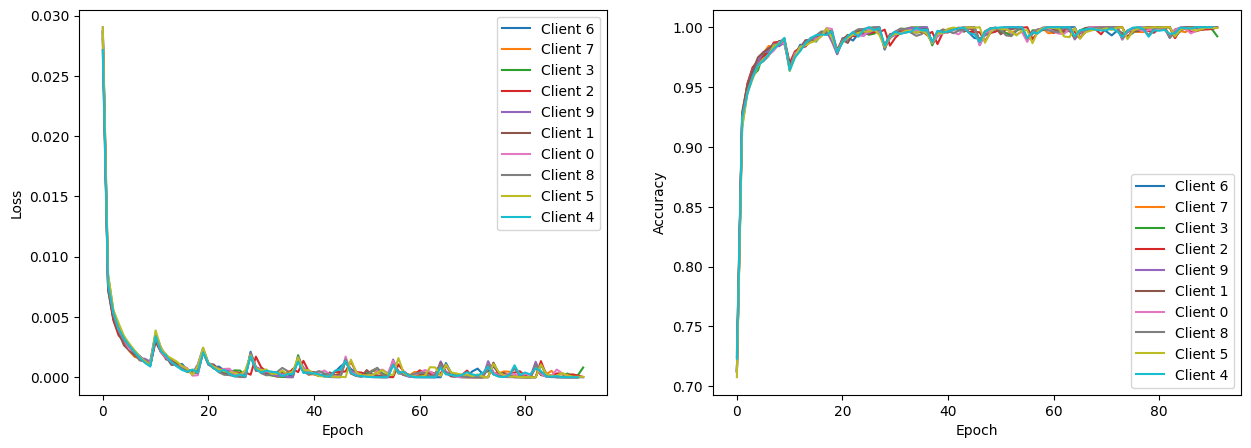

In [20]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.show()

plot_metrics(strategy.client_metrics)

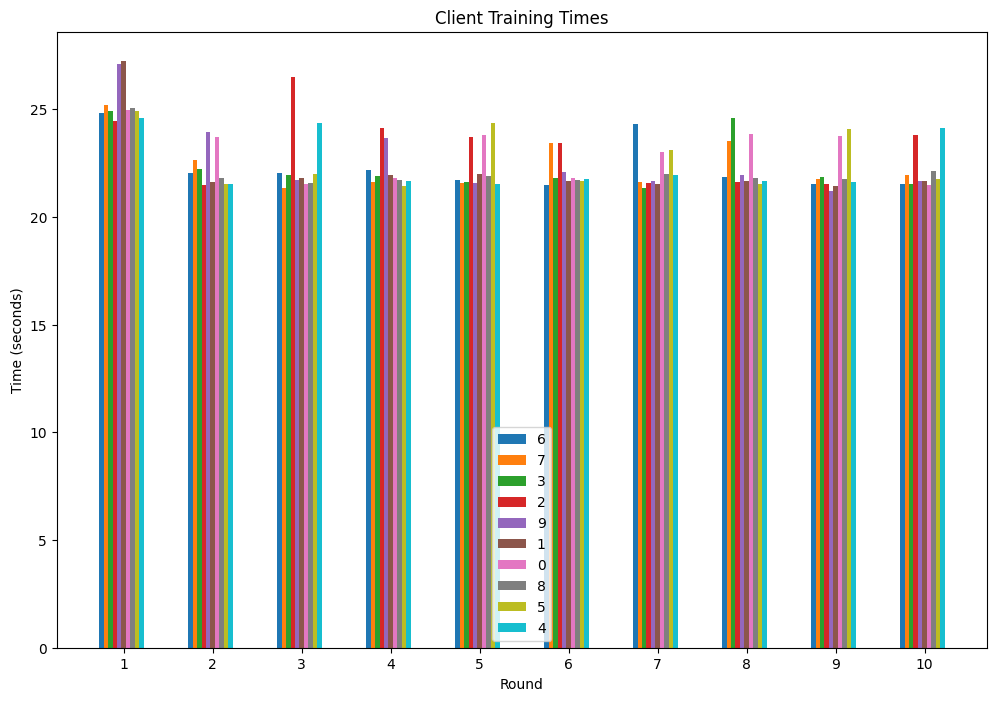

In [21]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()

    plt.show()

plot_times(strategy.client_training_times)

In [22]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 6 metrics: 92
Client 7 metrics: 91
Client 3 metrics: 92
Client 2 metrics: 92
Client 9 metrics: 91
Client 1 metrics: 91
Client 0 metrics: 91
Client 8 metrics: 91
Client 5 metrics: 92
Client 4 metrics: 91


In [23]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [24]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times = {}
        self.client_metrics = {}

    def parse_metrics(self, cid, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=10,
#     config=fl.server.ServerConfig(num_rounds=10),
#     client_resources=client_resources,
# )

In [25]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-16 11:19:33,198	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 31186078924.0, 'node:127.0.0.1': 1.0, 'memory': 62767517492.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51940) [Client 1] get_parameters
(ClientAppActor pid=51940) [Client 5] fit, config: {}
(ClientAppActor pid=51940) Epoch 0: train loss 0.029290, accuracy 0.698704
(ClientAppActor pid=46828) [Client 0] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51940) Epoch 1: train loss 0.008288, accuracy 0.922407
(ClientAppActor pid=51940) Epoch 2: train loss 0.005695, accuracy 0.941852
(ClientAppActor pid=46828) Epoch 0: train loss 0.027693, accuracy 0.723148 [repeated 4x across cluster]
(ClientAppActor pid=55284) [Client 2] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=48396) Epoch 2: train loss 0.005420, accuracy 0.946481 [repeated 18x across cluster]
(ClientAppActor pid=55284) Epoch 4: train loss 0.002946, accuracy 0.967963 [repeated 17x across cluster]
(ClientAppActor pid=4868) Epoch 7: train loss 0.001284, accuracy 0.985741 [repeated 17x across cluster]
(ClientAppActor pid=51940) [Client 8] fit, config: {}
(ClientAppActor pid=4868) Epoc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=4868) Epoch 9: train loss 0.001057, accuracy 0.988519 [repeated 3x across cluster]
(ClientAppActor pid=51940) [Client 9] evaluate, config: {}
(ClientAppActor pid=4868) Client 1 loss 0.003462101292485992
(ClientAppActor pid=4868) Client 1 accuracy 0.9683333333333334


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46828) [Client 4] fit, config: {}
(ClientAppActor pid=46828) Epoch 1: train loss 0.002013, accuracy 0.978519 [repeated 9x across cluster]
(ClientAppActor pid=46828) [Client 4] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=46828) Client 4 loss 0.0036291405589630207 [repeated 9x across cluster]
(ClientAppActor pid=46828) Client 4 accuracy 0.9616666666666667 [repeated 9x across cluster]
(ClientAppActor pid=48396) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=45828) Epoch 3: train loss 0.001005, accuracy 0.988704 [repeated 20x across cluster]
(ClientAppActor pid=51940) Epoch 5: train loss 0.000541, accuracy 0.995000 [repeated 18x across cluster]
(ClientAppActor pid=45828) 
(ClientAppActor pid=57700) Epoch 8: train loss 0.000446, accuracy 0.995556 [repeated 18x across cluster]
(ClientAppActor pid=57700) [Client 6] fit, config: {}
(ClientAppActor pid=46828) Epoch 0: train loss 0.003189, accuracy 0.966852 [repeated 17x 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46828) [Client 0] evaluate, config: {}
(ClientAppActor pid=46828) Client 0 loss 0.0028075452375196618
(ClientAppActor pid=46828) Client 0 accuracy 0.98


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57700) [Client 4] fit, config: {}
(ClientAppActor pid=57700) Epoch 0: train loss 0.002011, accuracy 0.978704 [repeated 3x across cluster]
(ClientAppActor pid=57700) [Client 2] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=57700) Client 2 loss 0.001425739280578758 [repeated 9x across cluster]
(ClientAppActor pid=57700) Client 2 accuracy 0.9816666666666667 [repeated 9x across cluster]
(ClientAppActor pid=48396) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=55284) Epoch 2: train loss 0.000748, accuracy 0.992593 [repeated 18x across cluster]
(ClientAppActor pid=45828) Epoch 4: train loss 0.000370, accuracy 0.996481 [repeated 19x across cluster]
(ClientAppActor pid=56380) Epoch 6: train loss 0.000361, accuracy 0.996852 [repeated 18x across cluster]
(ClientAppActor pid=57700) Epoch 9: train loss 0.000010, accuracy 1.000000 [repeated 17x across cluster]
(ClientAppActor pid=57700) [Client 1] fit, config: {}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57700) Epoch 9: train loss 0.000020, accuracy 1.000000 [repeated 4x across cluster]
(ClientAppActor pid=46828) [Client 6] evaluate, config: {}
(ClientAppActor pid=46828) Client 6 loss 0.0017494213328124412
(ClientAppActor pid=46828) Client 6 accuracy 0.985


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57700) [Client 9] fit, config: {}
(ClientAppActor pid=57700) Epoch 1: train loss 0.000777, accuracy 0.991481 [repeated 10x across cluster]
(ClientAppActor pid=57700) [Client 2] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=57700) Client 2 loss 0.0011659677470621924 [repeated 9x across cluster]
(ClientAppActor pid=57700) Client 2 accuracy 0.9883333333333333 [repeated 9x across cluster]
(ClientAppActor pid=4868) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=55284) Epoch 3: train loss 0.000193, accuracy 0.997778 [repeated 18x across cluster]
(ClientAppActor pid=45828) Epoch 5: train loss 0.000282, accuracy 0.997778 [repeated 19x across cluster]
(ClientAppActor pid=4868) Epoch 7: train loss 0.000167, accuracy 0.998519 [repeated 18x across cluster]
(ClientAppActor pid=48396) [Client 4] fit, config: {}
(ClientAppActor pid=4868) Epoch 9: train loss 0.000036, accuracy 0.999444 [repeated 16x across cluster]
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55284) [Client 7] evaluate, config: {}
(ClientAppActor pid=55284) Client 7 loss 0.0018988640087373673
(ClientAppActor pid=55284) Client 7 accuracy 0.9866666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55284) [Client 8] fit, config: {}
(ClientAppActor pid=55284) Epoch 9: train loss 0.000003, accuracy 1.000000 [repeated 3x across cluster]
(ClientAppActor pid=55284) [Client 6] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=45828) Client 2 loss 0.001075083669234118 [repeated 9x across cluster]
(ClientAppActor pid=45828) Client 2 accuracy 0.99 [repeated 9x across cluster]
(ClientAppActor pid=4868) [Client 1] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=46828) Epoch 2: train loss 0.000468, accuracy 0.995741 [repeated 17x across cluster]
(ClientAppActor pid=55284) Epoch 4: train loss 0.000143, accuracy 0.998333 [repeated 20x across cluster]
(ClientAppActor pid=4868) Epoch 6: train loss 0.000360, accuracy 0.996111 [repeated 19x across cluster]
(ClientAppActor pid=46828) Epoch 9: train loss 0.000003, accuracy 1.000000 [repeated 17x across cluster]
(ClientAppActor pid=46828) [Client 3] fit, config: {}
(ClientAppActor pid=51940) Ep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51940) Epoch 9: train loss 0.000657, accuracy 0.992963 [repeated 4x across cluster]
(ClientAppActor pid=51940) [Client 6] evaluate, config: {}
(ClientAppActor pid=46828) Client 4 loss 0.0012616506321262476
(ClientAppActor pid=46828) Client 4 accuracy 0.9866666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46828) [Client 0] fit, config: {}
(ClientAppActor pid=46828) Epoch 1: train loss 0.000363, accuracy 0.996667 [repeated 10x across cluster]
(ClientAppActor pid=57700) [Client 9] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=57700) Client 9 loss 0.0008617936400196414 [repeated 9x across cluster]
(ClientAppActor pid=57700) Client 9 accuracy 0.9916666666666667 [repeated 9x across cluster]
(ClientAppActor pid=4868) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=51940) Epoch 3: train loss 0.000134, accuracy 0.998704 [repeated 20x across cluster]
(ClientAppActor pid=45828) Epoch 5: train loss 0.000026, accuracy 0.999630 [repeated 17x across cluster]
(ClientAppActor pid=55284) Epoch 7: train loss 0.000693, accuracy 0.993704 [repeated 18x across cluster]
(ClientAppActor pid=57700) [Client 6] fit, config: {}
(ClientAppActor pid=57700) Epoch 0: train loss 0.001095, accuracy 0.990370 [repeated 17x across cluster]
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46828) [Client 7] evaluate, config: {}
(ClientAppActor pid=46828) Client 7 loss 0.0015179469194163174
(ClientAppActor pid=46828) Client 7 accuracy 0.9883333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46828) Epoch 9: train loss 0.000128, accuracy 0.998889 [repeated 3x across cluster]
(ClientAppActor pid=57700) [Client 4] fit, config: {}
(ClientAppActor pid=57700) [Client 4] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=57700) Client 4 loss 0.0013021866745491668 [repeated 9x across cluster]
(ClientAppActor pid=57700) Client 4 accuracy 0.99 [repeated 9x across cluster]
(ClientAppActor pid=57700) Epoch 1: train loss 0.000328, accuracy 0.996296 [repeated 10x across cluster]
(ClientAppActor pid=45828) [Client 7] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=48396) Epoch 3: train loss 0.000126, accuracy 0.998704 [repeated 19x across cluster]
(ClientAppActor pid=55284) Epoch 5: train loss 0.000022, accuracy 0.999815 [repeated 18x across cluster]
(ClientAppActor pid=46828) Epoch 8: train loss 0.000067, accuracy 0.999444 [repeated 18x across cluster]
(ClientAppActor pid=46828) [Client 6] fit, config: {}
(ClientAppActor pid=46828)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=4868) [Client 9] evaluate, config: {}
(ClientAppActor pid=4868) Client 9 loss 0.0005901486090325155
(ClientAppActor pid=4868) Client 9 accuracy 0.9966666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46828) [Client 4] fit, config: {}
(ClientAppActor pid=46828) Epoch 0: train loss 0.000978, accuracy 0.990926 [repeated 3x across cluster]
(ClientAppActor pid=46828) [Client 8] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=46828) Client 8 loss 0.0007229478646382858 [repeated 9x across cluster]
(ClientAppActor pid=46828) Client 8 accuracy 0.9933333333333333 [repeated 9x across cluster]
(ClientAppActor pid=51940) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=48396) Epoch 2: train loss 0.000190, accuracy 0.997778 [repeated 17x across cluster]
(ClientAppActor pid=56380) Epoch 4: train loss 0.000028, accuracy 0.999815 [repeated 20x across cluster]
(ClientAppActor pid=46828) Epoch 7: train loss 0.000002, accuracy 1.000000 [repeated 19x across cluster]
(ClientAppActor pid=46828) [Client 7] fit, config: {}
(ClientAppActor pid=56380) Epoch 9: train loss 0.000441, accuracy 0.995370 [repeated 17x across cluster]
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56380) [Client 5] evaluate, config: {}
(ClientAppActor pid=56380) Client 5 loss 0.001954544698043795
(ClientAppActor pid=56380) Client 5 accuracy 0.99


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55284) [Client 0] fit, config: {}
(ClientAppActor pid=55284) Epoch 0: train loss 0.001169, accuracy 0.991111 [repeated 3x across cluster]
(ClientAppActor pid=55284) [Client 3] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=55284) Client 3 loss 0.0026119992428442628 [repeated 9x across cluster]
(ClientAppActor pid=55284) Client 3 accuracy 0.9816666666666667 [repeated 9x across cluster]
(ClientAppActor pid=46828) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=46828) Epoch 2: train loss 0.000119, accuracy 0.998889 [repeated 19x across cluster]
(ClientAppActor pid=45828) Epoch 4: train loss 0.000066, accuracy 0.999444 [repeated 18x across cluster]
(ClientAppActor pid=48396) Epoch 6: train loss 0.000002, accuracy 1.000000 [repeated 18x across cluster]
(ClientAppActor pid=56380) Epoch 9: train loss 0.000001, accuracy 1.000000 [repeated 17x across cluster]
(ClientAppActor pid=56380) [Client 1] fit, config: {}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55284) [Client 8] evaluate, config: {}
(ClientAppActor pid=55284) Client 8 loss 0.0008452698635549775
(ClientAppActor pid=55284) Client 8 accuracy 0.995


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56380) [Client 9] fit, config: {}
(ClientAppActor pid=55284) Epoch 1: train loss 0.000305, accuracy 0.996296 [repeated 10x across cluster]
(ClientAppActor pid=56380) [Client 0] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=56380) Client 0 loss 0.0032609756023350596 [repeated 9x across cluster]
(ClientAppActor pid=56380) Client 0 accuracy 0.9833333333333333 [repeated 9x across cluster]
(ClientAppActor pid=57700) [Client 3] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=51940) Epoch 3: train loss 0.000039, accuracy 0.999815 [repeated 18x across cluster]
(ClientAppActor pid=46828) Epoch 5: train loss 0.000121, accuracy 0.998889 [repeated 20x across cluster]
(ClientAppActor pid=55284) Epoch 7: train loss 0.000117, accuracy 0.998704 [repeated 17x across cluster]
(ClientAppActor pid=51940) [Client 2] fit, config: {}
(ClientAppActor pid=51940) Epoch 0: train loss 0.001256, accuracy 0.991111 [repeated 17x across cluster]
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45828) [Client 5] evaluate, config: {}
(ClientAppActor pid=45828) Client 5 loss 0.002440537388323302
(ClientAppActor pid=45828) Client 5 accuracy 0.99


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 525.00s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0036222374315063154
INFO :      		round 2: 0.0019793802565642787
INFO :      		round 3: 0.0019538444073120523
INFO :      		round 4: 0.0019344791223141443
INFO :      		round 5: 0.0019032931652087466
INFO :      		round 6: 0.001782252038516494
INFO :      		round 7: 0.0017490617420595786
INFO :      		round 8: 0.0018109325330709063
INFO :      		round 9: 0.001757214188742724
INFO :      		round 10: 0.0017818321818540092
INFO :      


History (loss, distributed):
	round 1: 0.0036222374315063154
	round 2: 0.0019793802565642787
	round 3: 0.0019538444073120523
	round 4: 0.0019344791223141443
	round 5: 0.0019032931652087466
	round 6: 0.001782252038516494
	round 7: 0.0017490617420595786
	round 8: 0.0018109325330709063
	round 9: 0.001757214188742724
	round 10: 0.0017818321818540092

(ClientAppActor pid=57700) Client 8 loss 0.0011366552068903957
(ClientAppActor pid=57700) Client 8 accuracy 0.9916666666666667


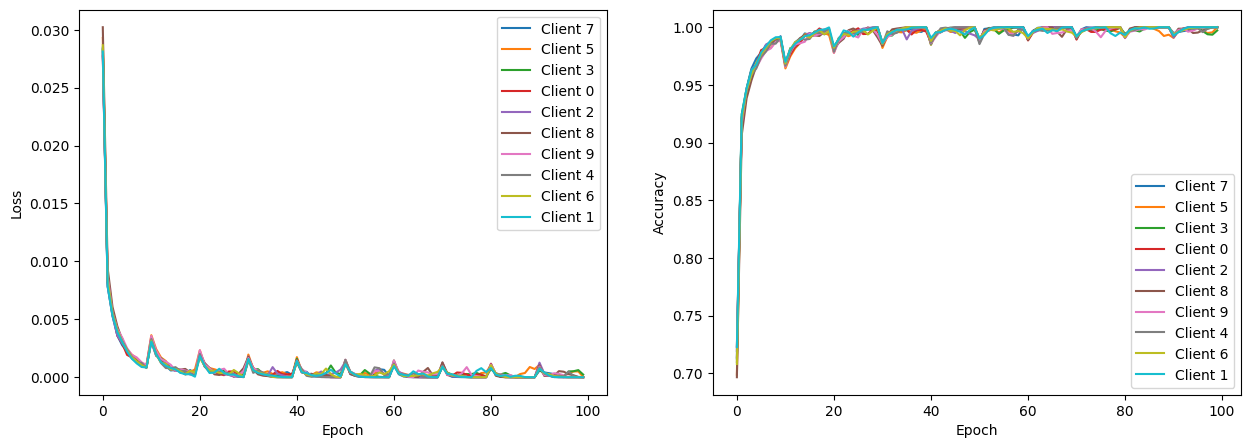

In [26]:
plot_metrics(strategy_fed_avg.client_metrics)

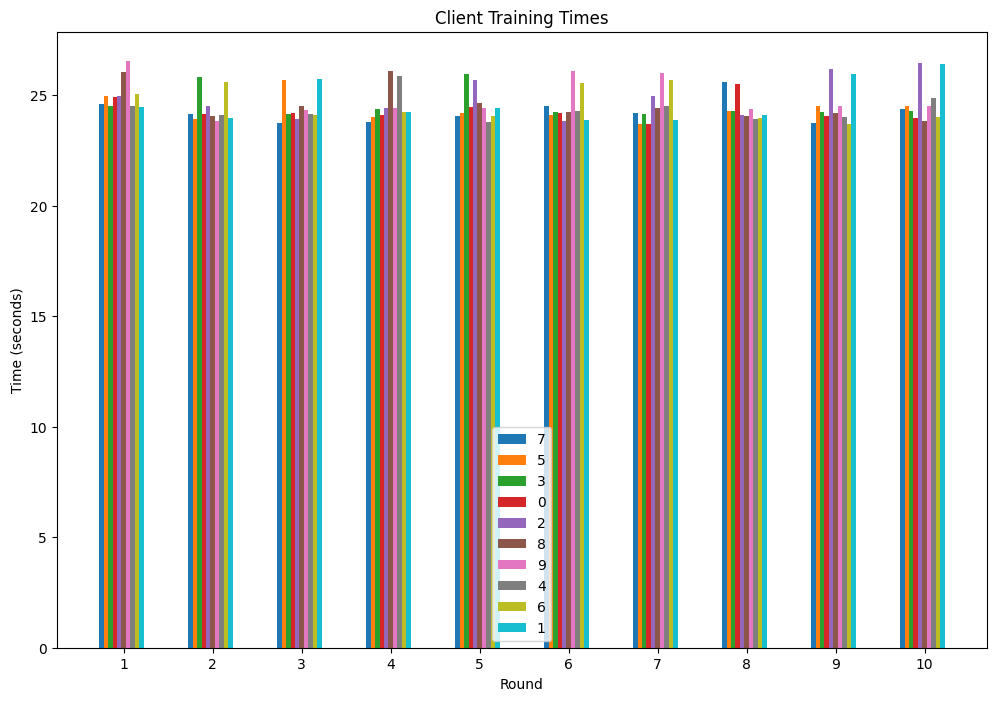

In [27]:
plot_times(strategy_fed_avg.client_training_times)